In [1]:
import gym
import option_price_process
import HedgeEnv_PPO
import HedgeEnv_DQN
import numpy as np
import torch
import matplotlib.pyplot as plt
import tensorflow as tf
from asset_price_process import GBM
from option_price_process import BSM
from HedgeEnv import env_hedging
from torch import nn
import time


In [3]:
mu = 0
dt = 1/5
T = 10
num_steps = int(T/dt)
s_0 = float(100)
strike_price = s_0
sigma = 0.1
r = 0

def cost(delta_h, multiplier):
    TickSize = 0.1
    return multiplier * TickSize * (np.abs(delta_h) + 0.01 * delta_h**2)


apm = GBM(mu=mu, dt=dt, s_0=s_0, sigma=sigma)
opm = BSM(strike_price=strike_price, risk_free_interest_rate=r, volatility=sigma, T=T, dt=dt)
env = HedgeEnv_PPO.env_hedging(asset_price_model=apm, dt=dt, T=T, num_steps=num_steps, cost_multiplier = 5, tick_size=0.01,
                     L=1, strike_price=strike_price, int_holdings=True, initial_holding=0, mode="PL",
                  option_price_model=opm)




In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.utils import get_schedule_fn
import os 

class CustomFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 201):
        super(CustomFeatureExtractor, self).__init__(observation_space, features_dim)
        
        # Assuming the input is a 1D vector, reshape it to (batch_size, sequence_length, features)
        input_dim = observation_space.shape[0]

        self.fc_net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),  # Batch Normalization after the first linear layer
            nn.ReLU(),
            
            nn.Linear(128, 256),
            nn.BatchNorm1d(256), 
            nn.ReLU(),
            
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),  
            nn.ReLU(),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),  
            nn.ReLU(),
            
            nn.Linear(128, features_dim),
            nn.BatchNorm1d(features_dim), 
            nn.ReLU()
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.fc_net(observations)
    
lr_schedule = get_schedule_fn(1e-4)

from stable_baselines3.common.callbacks import BaseCallback

class RewardCallback(BaseCallback):
    def __init__(self, check_freq: int, verbose=1):
        super(RewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.rewards = []

    def _on_step(self) -> bool:
        # Save the reward for this step
        reward = self.locals["rewards"][0]  # Access the current reward
        if self.n_calls % self.check_freq == 0:
            self.rewards.append(reward)  # Log rewards at each check frequency
        return True

# Usage
callback = RewardCallback(check_freq=1000, verbose=1)

models_dir = "models/PPO"
logdir = "logs"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)


model = PPO(policy="MlpPolicy", 
    env=env,
    learning_rate=lr_schedule,
    verbose=1,
    gamma= 0.85, 
    batch_size=32, 
    policy_kwargs=dict(features_extractor_class=CustomFeatureExtractor),
    tensorboard_log= logdir)

TIMESTEPS = 3000000
for i in range(1,2):
    model.learn(total_timesteps= TIMESTEPS, reset_num_timesteps= False, tb_log_name="PPO", callback= callback )
    model.save(f"{models_dir}/{TIMESTEPS*i}")



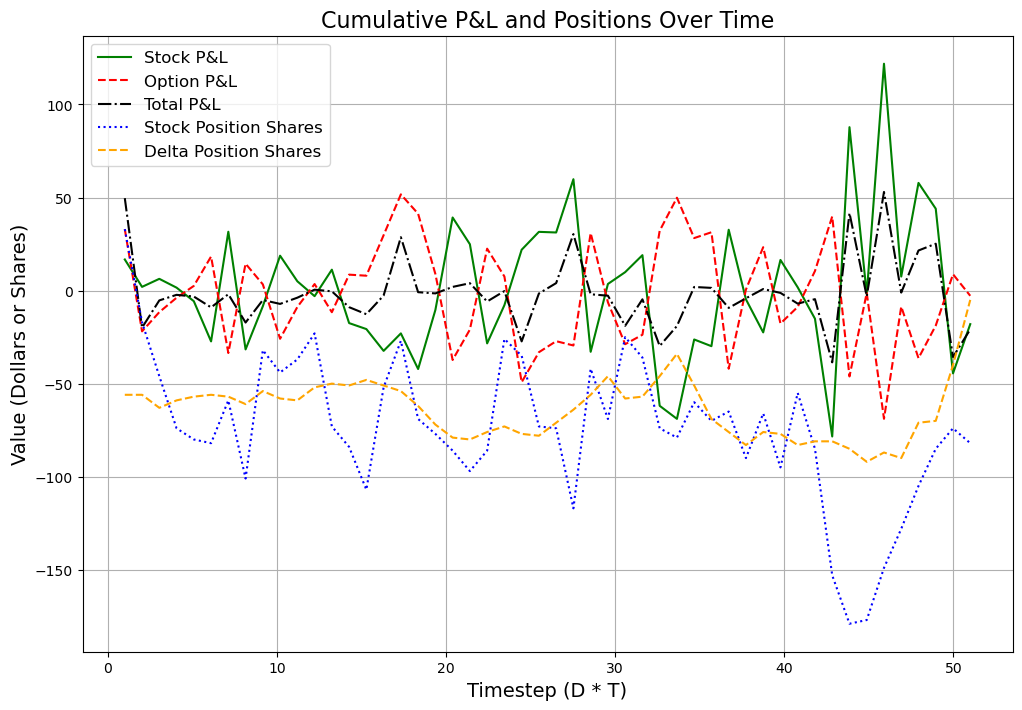

In [19]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.utils import get_schedule_fn
import os 

model = PPO.load("models/PPO/1700000.zip")
num_episodes = 1

for episode in range(num_episodes): 
    state = env.reset()
    done = False
    cum_option_pnl = 0
    cum_stock_pnl = 0
    cum_cost_pnl = 0
    option_pnls = []
    stock_pnls = []
    cost_pnls = []
    total_pnl = []
    stock_pos_shares =[]
    delta_pos_shares = []
    
    while not done:
        current_state = env.get_state()
        delta_action = -100 * round(current_state[4], 2)
        action, _states = model.predict(current_state, deterministic = False)
        next_state, reward, done, info = env.step(action)
        delta_h =   next_state[0] -current_state[0]
        option_pnl = (100*(next_state[3]-current_state[3]))/10
        stock_pnl = (-next_state[0]*(next_state[1] -current_state[1])- cost(delta_h, 5))/10
        cum_option_pnl =+ option_pnl
        cum_stock_pnl =+ stock_pnl
        cum_cost_pnl =+ cost(delta_h, 5)

        option_pnls.append(cum_option_pnl)
        stock_pnls.append(cum_stock_pnl)
        cost_pnls.append(cum_cost_pnl)
        total_pnl.append(cum_option_pnl+cum_stock_pnl)
        stock_pos_shares.append(-next_state[0])
        delta_pos_shares.append(delta_action)

        if done:
            state = env.reset()

    time_axis = np.linspace(1, num_steps+1, num_steps)
    plt.figure(figsize=(12, 8))
    plt.plot(time_axis, stock_pnls, label='Stock P&L', color='green', linestyle='-')
    plt.plot(time_axis, option_pnls, label='Option P&L', color='red', linestyle='--')
    #plt.plot(time_axis, cost_pnls, label='Cost P&L', color='magenta', linestyle='--')
    plt.plot(time_axis, total_pnl, label='Total P&L', color='black', linestyle='-.')
    plt.plot(time_axis, stock_pos_shares, label='Stock Position Shares', color='blue', linestyle=':')
    plt.plot(time_axis, delta_pos_shares, label='Delta Position Shares', color='orange', linestyle='--')

    # Add labels, title, and legend
    plt.xlabel('Timestep (D * T)', fontsize=14)
    plt.ylabel('Value (Dollars or Shares)', fontsize=14)
    plt.title('Cumulative P&L and Positions Over Time', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    #plt.savefig("models/PPO/Cost5")

    plt.show()

In [ ]:
from scipy.ndimage import gaussian_filter1d

# Calculate moving average to smooth the curve
window_size = 50 # Adjust the window size as needed
smoothed_rewards = np.convolve(callback.rewards, np.ones(window_size)/window_size, mode='valid')

# Alternatively, you can use Gaussian smoothing for more flexible control:
# smoothed_rewards = gaussian_filter1d(callback.rewards, sigma=2)

# Adjust train_data_point to match the length of smoothed_rewards
train_data_point = np.arange(len(smoothed_rewards)) * callback.check_freq

plt.figure(figsize=(10, 6))
plt.plot(train_data_point, smoothed_rewards, label='Reward', color='green')
plt.xlabel('Timesteps', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.title('Convergence of PPO - Reward Over Training', fontsize=16)
plt.legend(loc='best')
plt.grid(True)
plt.savefig("PPO_Convergence_3000000.png")
plt.show()


C:\Users\levyb\AppData\Local\Temp\ipykernel_5268\1207413655.py:73: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cost_pnls_reinf, label='Policy: reinf', shade=True)
C:\Users\levyb\AppData\Local\Temp\ipykernel_5268\1207413655.py:74: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cost_pnls_dh, label='Policy: $\delta_{DH}$', shade=True)
C:\Users\levyb\AppData\Local\Temp\ipykernel_5268\1207413655.py:82: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(total_pnls_vol_reinf, label='Policy: reinf', shade=True)
C:\Users\levyb\AppData\Local\Temp\ipykernel_5268\1207413655.py:83: FutureWarning: 

`shade` is now deprecated in favor of `

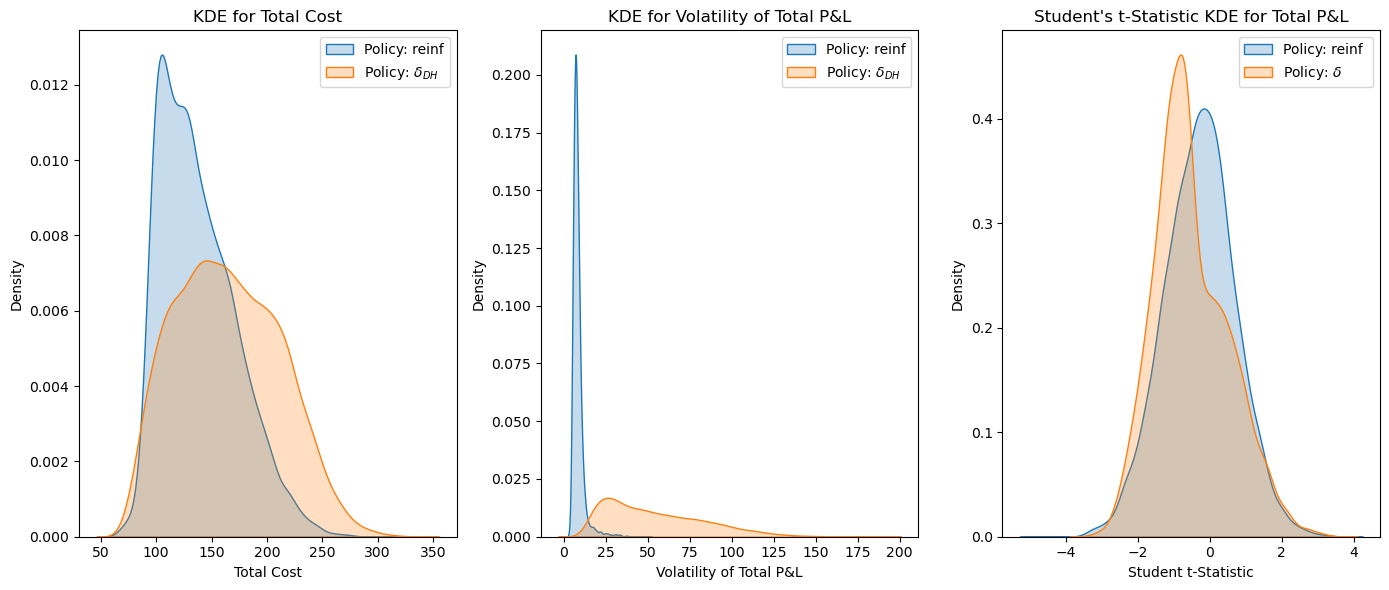

In [20]:
def student_t_statistic(data):
    n = len(data)
    sample_mean = np.mean(data)
    sample_std = np.std(data, ddof=1)
    t_statistic = sample_mean / (sample_std / np.sqrt(n))
    return t_statistic

# Getting kernel density estimates for cost and volatility 
num_episodes = 10000
cost_pnls_dh= []
cost_pnls_reinf = []
total_pnls_vol_dh =[]
total_pnls_vol_reinf = []

t_stat_pnl_dh = []
t_stat_pnl_reinf = []

for episode in range(num_episodes): 
    state = env.reset()
    done = False
    dh_actions = [0]
    cum_cost_pnl_dh = 0
    cum_cost_pnl_reinf = 0
    cum_total_pnl_dh = []
    cum_total_pnl_reinf = [] 
    deltas =[]
    
    while not done:
        current_state = env.get_state()
        delta_action = -100 * round(current_state[4], 2)
        delta_h_dh= delta_action - dh_actions[-1]
        deltas.append(delta_h_dh)
        dh_actions.append(delta_action)

        action, _states = model.predict(current_state, deterministic = True)
        next_state, reward, done, info = env.step(action-0)
        delta_h_reinf =   next_state[0] -current_state[0]
        

        cum_cost_pnl_dh += cost(delta_h_dh, 5)
        cum_cost_pnl_reinf += cost(delta_h_reinf, 5)

        total_pnl_reinf = ((100*(next_state[3]-current_state[3])) + (-next_state[0]*(next_state[1] -current_state[1])- cost(delta_h_reinf, 5)))/10
        total_pnl_dh = ((100*(next_state[3]-current_state[3])) + (-delta_action*(next_state[1] -current_state[1])- cost(delta_h_dh, 5)))/10
        cum_total_pnl_reinf.append(total_pnl_reinf)
        cum_total_pnl_dh.append(total_pnl_dh)
        
        if done:
            state = env.reset()

    vol_reinf = np.std(cum_total_pnl_reinf)
    vol_dh = np.std(cum_total_pnl_dh)

    student_t_reinf = student_t_statistic(cum_total_pnl_reinf)
    student_t_dh = student_t_statistic(cum_total_pnl_dh)

    cost_pnls_reinf.append(cum_cost_pnl_reinf)
    cost_pnls_dh.append(cum_cost_pnl_dh)
    total_pnls_vol_reinf.append(vol_reinf)
    total_pnls_vol_dh.append(vol_dh)
    t_stat_pnl_reinf.append(student_t_reinf)
    t_stat_pnl_dh.append(student_t_dh)



from scipy import stats
import seaborn as sns

# Plot kernel density estimates for total cost
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.kdeplot(cost_pnls_reinf, label='Policy: reinf', shade=True)
sns.kdeplot(cost_pnls_dh, label='Policy: $\delta_{DH}$', shade=True)
plt.title('KDE for Total Cost')
plt.xlabel('Total Cost')
plt.ylabel('Density')
plt.legend()

# Plot kernel density estimates for volatility of total P&L
plt.subplot(1, 3, 2)
sns.kdeplot(total_pnls_vol_reinf, label='Policy: reinf', shade=True)
sns.kdeplot(total_pnls_vol_dh, label='Policy: $\delta_{DH}$', shade=True)
plt.title('KDE for Volatility of Total P&L')
plt.xlabel('Volatility of Total P&L')
plt.ylabel('Density')
plt.legend()

# Plot KDE for Student's t-statistic of Total P&L
plt.subplot(1, 3, 3)
sns.kdeplot(t_stat_pnl_reinf, label='Policy: reinf ', shade=True)
sns.kdeplot(t_stat_pnl_dh, label='Policy: $\delta$', shade=True)
plt.title("Student's t-Statistic KDE for Total P&L")
plt.xlabel('Student t-Statistic')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()

plt.savefig("models/PPO/PPO_KernelDensities_10000")
plt.show()
